<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/Phantom_siameseNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import tqdm

In [2]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1) 
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # img0 = img0.convert("P")  # .convert("L") for one-channel (black and white) image
        # img1 = img1.convert("P")  # .convert("L") for one-channel (black and white) image

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

    def visualize_data(self, should_get_same_class: bool):
        """Method to visualize a pair of images from the dataset. This allows 
        you to check if your dataset is correctly built. Mainly that if you 
        select the "same" class, the results show the same person.

        :param should_get_same_class: Boolean to indicate if the images should 
        belong to the same class or not.
        :type should_get_same_class: bool
        :return: Plots the two images side-by-side for comparison, and outputs 
        a text that clarifies if they belong to the same class or not.
        :rtype: NoneType
        """
        img0_tuple = random.choice(self.imageFolderDataset)
        img0_tuple = self.transform(img0_tuple[0]), img0_tuple[1]
        class_value = img0_tuple[1]
        iteration = 0

        ndims, base, height = np.array(img0_tuple[0].shape)

        if should_get_same_class:
            text = 'Same class. Target = 0'
            img1_tuple = 0, class_value + 1
            while ((img1_tuple[1] != class_value) and (iteration < 1000)):
              img1_tuple = random.choice(folder_dataset)
              iteration += 1

        else:
            text = 'Not the same class. Target = 1'
            img1_tuple = 0, class_value
            while ((img1_tuple[1] == class_value) and (iteration < 1000)):
                img1_tuple = random.choice(folder_dataset)
                iteration += 1

        img0 = img0_tuple[0]
        img1 = self.transform(img1_tuple[0])

        reshape = [1] + [ndims, base, height]

        img0 = torch.Tensor(np.array(img0).reshape(reshape))
        img1 = torch.Tensor(np.array(img1).reshape(reshape))

        concatenated = torch.cat((img0, img1), 0)
        imshow(torchvision.utils.make_grid(concatenated))
        print(text)

        return None

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [4]:
# !wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
# !rm -rf data
# !unzip "at&t.zip" -d .

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/ULTRADATA/Motos/Train")

In [7]:
# Resize the images and transform to tensors
img_resize = (224, 224)

transformation = transforms.Compose([transforms.Resize(img_resize),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

Quiero hacer un método que me muestre dos fotos aleatorias de la misma categoría o de distinta categoría!

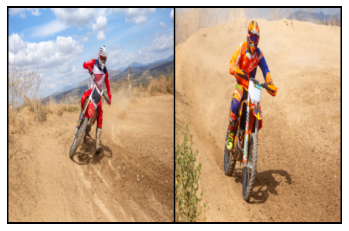

Not the same class. Target = 1


In [8]:
siamese_dataset.visualize_data(should_get_same_class=False)

In [9]:
siamese_dataset1 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
siamese_dataset2 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
siamese_dataset3 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
siamese_dataset4 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

dataset_list = []

for _ in range(5):
  siam_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
  dataset_list.append(siam_dataset)

concat_dataset = torch.utils.data.ConcatDataset(dataset_list)

In [10]:
len(concat_dataset)

1450

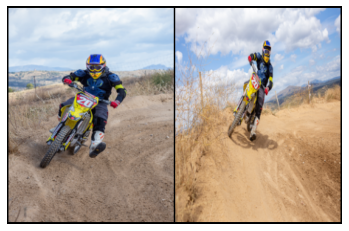

[0.]


In [11]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=1)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, and also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

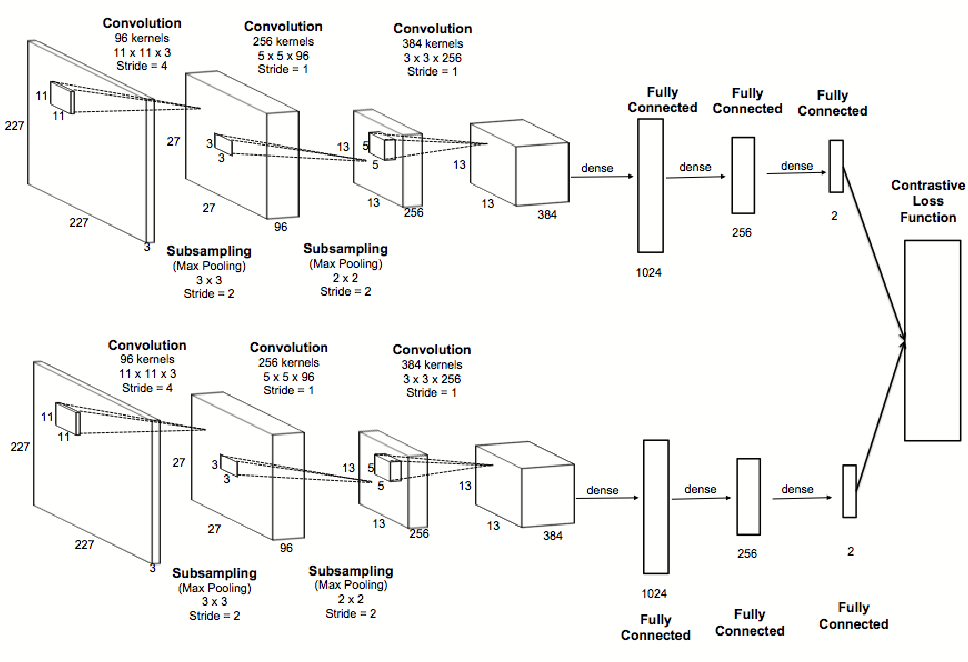

In [12]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True),

            # prueba:
            nn.AdaptiveMaxPool2d(6)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(13824, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

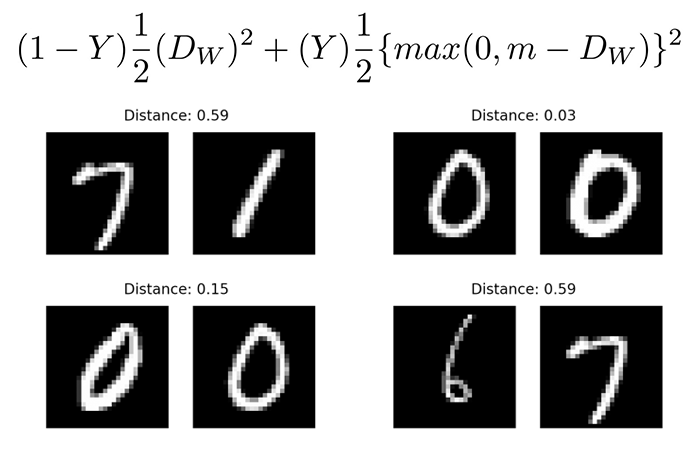

In [13]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [16]:
# Load the training dataset
train_dataloader = DataLoader(concat_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=16)

In [17]:
# batch = next(iter(train_dataloader))

In [18]:
len(train_dataloader)

91

In [19]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

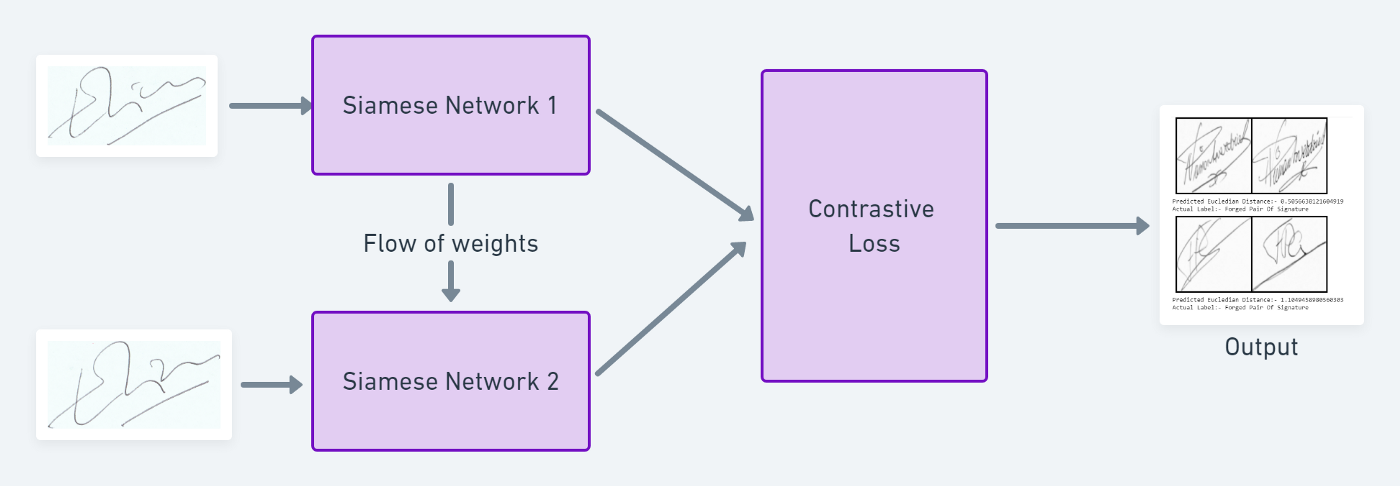

In [20]:
counter = []
loss_history = [] 
avg_loss_history = []
running_loss = 0
iteration_number= 0

# Iterate throught the epochs
for epoch in range(30):

    # Create a progress bar for each epoch
    progress_bar = tqdm(train_dataloader)

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(progress_bar, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda() # img0, img1, label

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)
        running_loss += loss_contrastive.item()

        avg_loss = running_loss / i

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            avg_loss_history.append(avg_loss)

show_plot(counter, loss_history)

Epoch number 0
 Current loss 1.497003197669983

Epoch number 0
 Current loss 1.6210949420928955

Epoch number 0
 Current loss 1.713256597518921

Epoch number 0
 Current loss 1.6948598623275757

Epoch number 0
 Current loss 1.6449308395385742

Epoch number 0
 Current loss 1.4290997982025146

Epoch number 0
 Current loss 0.9404659867286682

Epoch number 0
 Current loss 0.8552665710449219

Epoch number 0
 Current loss 1.1225286722183228

Epoch number 0
 Current loss 0.9905376434326172

Epoch number 1
 Current loss 1.430943250656128

Epoch number 1
 Current loss 1.2375195026397705

Epoch number 1
 Current loss 1.052851915359497

Epoch number 1
 Current loss 1.1808621883392334

Epoch number 1
 Current loss 0.9459513425827026

Epoch number 1
 Current loss 0.7002302408218384

Epoch number 1
 Current loss 0.9303057193756104

Epoch number 1
 Current loss 0.9408271908760071

Epoch number 1
 Current loss 1.1619635820388794

Epoch number 1
 Current loss 1.7340259552001953

Epoch number 2
 Current 

KeyboardInterrupt: ignored

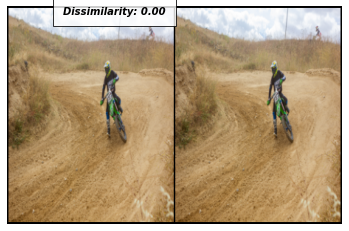

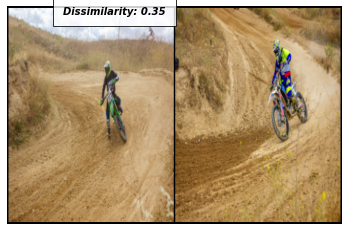

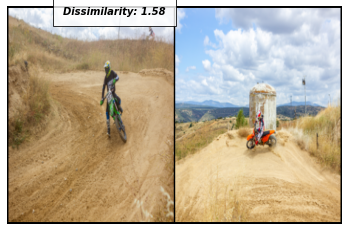

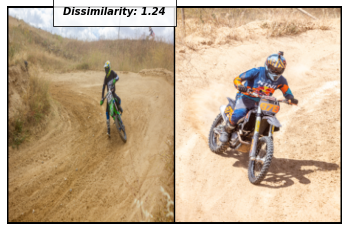

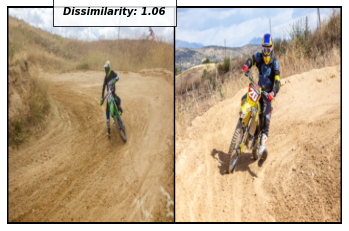

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="/content/drive/MyDrive/ULTRADATA/Motos/Test")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 10 images and test them with the first image (x0)
    if i % 5 == 0:
      x1 = x0
    else:
      _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0, x1) #net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## Calculate Accuracy

In [ ]:
import os

In [ ]:
train_directory = os.listdir('/content/drive/MyDrive/ULTRADATA/surf_images/labeled_images/Train')

for num_folder in train_directory:
  same_person_dir = os.listdir(f'/content/drive/MyDrive/ULTRADATA/surf_images/labeled_images/Train/{num_folder}')
  same_img_path = np.random.choice(same_person_dir, 1)

  while True:
    same_img2_path = np.random.choice(same_person_dir, 1)
    if same_img2_path != same_img_path:
      break

  while True:
    diff_img_base_path = np.random.choice(train_directory, 1)
    if diff_img_base_path != num_folder:
      break

  
  np.random.choice(train_directory, 1)

['01',
 '02',
 '04',
 '03',
 '06',
 '05',
 '10',
 '09',
 '14',
 '12',
 '11',
 '19',
 '17',
 '16',
 '15',
 '21',
 '28',
 '27',
 '24',
 '22',
 '30',
 '29',
 '35',
 '34',
 '33',
 '31',
 '39',
 '38',
 '37',
 '36',
 '40',
 '32',
 '43',
 '42']

In [ ]:
os.listdir(f'/content/drive/MyDrive/ULTRADATA/surf_images/labeled_images/Train/01')

['Copia de person01_2020 08 01 X wave - 9992.jpg',
 'Copia de person01_2020 08 01 X wave - 9999.jpg',
 'Copia de person01_2020 08 01 X wave - 0002.jpg']